## Segmentación de clientes

## Librerías

In [28]:
# Librerías para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para manipulación y análisis de datos
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from toolbox_DS import *

import warnings
warnings.filterwarnings('ignore')
pd.option_context('mode.use_inf_as_na', True)


## Carga de datos (train_set)

In [3]:
train_set = pd.read_csv('./data/train_set.csv')
train_set

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Response,income_missing,age,customes_seniority,Household_members,Total_amount,Total_purchase,Median_amount_purchase,Total_cmp,Total_%_cmp
0,9400,1958,2n Cycle,Single,85485.0,0,0,2014-06-21,73,630,...,0,0,57,1,1.0,1383,19,72.789474,0,0.0
1,2804,1975,Master,Single,46098.0,1,1,2012-08-18,86,57,...,1,0,40,3,3.0,120,11,10.909091,0,0.0
2,1503,1976,PhD,Together,162397.0,1,1,2013-06-03,31,85,...,0,0,39,2,4.0,107,1,107.000000,0,0.0
3,5491,1951,Master,Together,47352.0,0,1,2013-04-11,70,172,...,0,0,64,2,3.0,319,16,19.937500,0,0.0
4,2894,1985,Graduation,Single,72903.0,0,0,2013-10-29,74,1067,...,1,0,30,2,1.0,2013,21,95.857143,3,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785,10785,1969,Graduation,Married,44078.0,1,1,2014-06-19,17,24,...,0,0,46,1,4.0,41,7,5.857143,0,0.0
1786,9964,1979,Graduation,Single,61825.0,0,1,2013-08-07,56,162,...,0,0,36,2,2.0,424,15,28.266667,0,0.0
1787,3412,1951,Master,Married,67381.0,0,1,2013-01-15,67,815,...,0,0,64,2,3.0,957,17,56.294118,1,0.2
1788,2811,1963,PhD,Single,48918.0,1,1,2014-04-12,21,52,...,0,0,52,1,3.0,62,7,8.857143,0,0.0


In [4]:
train_set.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'income_missing', 'age',
       'customes_seniority', 'Household_members', 'Total_amount',
       'Total_purchase', 'Median_amount_purchase', 'Total_cmp', 'Total_%_cmp'],
      dtype='object')

In [5]:
# Cambio el índice
train_set.set_index('ID', inplace=True)

# Cambio tipo a datetime
train_set['Dt_Customer'] = pd.to_datetime(train_set['Dt_Customer'])

# Cambiar tipo a categóricas
cols_to_category = ['Education', 'Marital_Status']
train_set[cols_to_category] = train_set[cols_to_category].astype('category')

# Elimino columna 'income_missing'
train_set = train_set.drop(columns=['income_missing', 'Year_Birth','Total_%_cmp','Dt_Customer','Median_amount_purchase'])

# Elimino el outlier de Income
train_set = train_set.loc[train_set['Income'] !=666666]

## Tratamiento de variables

Selección de features por dtype

In [6]:
features_num = train_set.select_dtypes(['int','float']).columns
features_cat = train_set.select_dtypes(['object', 'category']).columns
print('features_num', features_num)
print('features_cat', features_cat)

features_num Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'age', 'customes_seniority',
       'Household_members', 'Total_amount', 'Total_purchase', 'Total_cmp'],
      dtype='object')
features_cat Index(['Education', 'Marital_Status'], dtype='object')


Preparación de las transformaciones

In [7]:
# Definimos el OrdinalEncoder con el mapeo de 'education_ode'
ordinal_encoder = OrdinalEncoder(categories=[['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']])

categorical_features_onehot = ['Marital_Status']
categorical_features_ordinal = ['Education']
numerical_features = features_num

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat_onehot', OneHotEncoder(), categorical_features_onehot),
        ('cat_ordinal', Pipeline([
            ('ordinal', ordinal_encoder),
            ('scaler', MinMaxScaler())
        ]), categorical_features_ordinal)
    ]
)

Primera valoración del KMeans con un rango entre 3 y 7 clúster

In [8]:
soluciones = list(range(3, 7))

codo = []
silueta = []
calins = []
davies = []

for solucion in soluciones:
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('kmeans', KMeans(random_state=42, n_clusters=solucion, n_init=10))
    ])
    
   
    pipeline.fit(train_set)
    
    # Obtenemos los datos transformados del paso 'preprocessor'
    X_transformed = pipeline.named_steps['preprocessor'].transform(train_set)
    
    # Obtenemos las etiquetas del cluster del paso 'kmeans'
    labels = pipeline.named_steps['kmeans'].labels_
    
    # Recoger las métricas usando los datos transformados
    codo.append(pipeline.named_steps['kmeans'].inertia_)
    silueta.append(silhouette_score(X_transformed, labels))
    calins.append(calinski_harabasz_score(X_transformed, labels))
    davies.append(davies_bouldin_score(X_transformed, labels))

Resultados a dataframe y visualización gráfica

In [9]:
metricas = pd.DataFrame({'Solucion':soluciones,
              'Codo': codo,
              'Silueta':silueta,
              'Calins':calins,           
              'Davies':davies}).set_index('Solucion')

metricas

,Codo,Silueta,Calins,Davies
Solucion,,,,
3,1.573084e+11,0.540368,3901.872531,0.557183
4,1.069945e+11,0.527466,4102.135807,0.571777
5,6.601299e+10,0.536208,5260.797257,0.462336
6,4.353306e+10,0.537179,6562.341503,0.458835


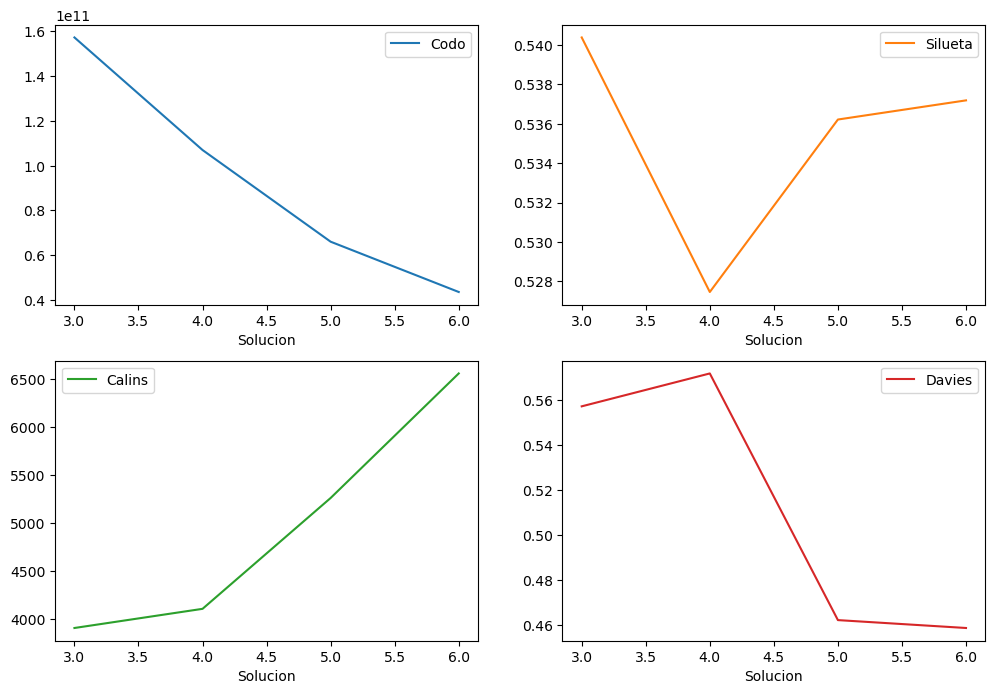

In [10]:
metricas.plot(subplots = True, figsize = (12,8), layout = (2,2), sharex = False);

Parece que estaría entre 4 y 5 sería el mejor número para los clúster.

In [11]:
# Instanciar el pipeline con el preprocesador y KMeans
pipeline = Pipeline(steps=[
       ('preprocessor', preprocessor),
       ('kmeans', KMeans(random_state=42, n_clusters=4, n_init=10))
   ])
    
# Entrenar el pipeline
pipeline.fit(train_set)
    
# Obtenemos los datos transformados del paso 'preprocessor'
X_transformed = pipeline.named_steps['preprocessor'].transform(train_set)
    
# Obtenemos las etiquetas del cluster del paso 'kmeans'
labels = pipeline.named_steps['kmeans'].labels_

# Si deseas añadir las etiquetas de los clusters al DataFrame original
train_set['Cluster'] = labels

In [12]:
train_set['Cluster'].value_counts()

Cluster
1    556
3    545
0    377
2    311
Name: count, dtype: int64

Elijo 4 dado que con 5 se me queda un último clúster muy pequeño (solo 7 personas)

## Análisis clúster con respecto a las variables

### Análisis con variables numéricas

Análisis de Income vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

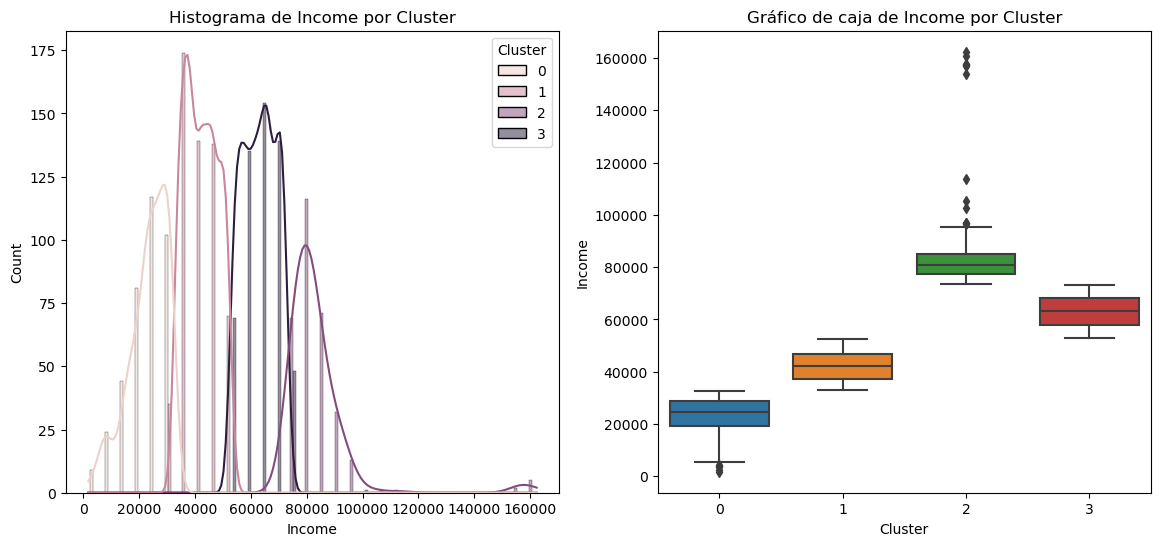

Estadísticos de resumen para Income por Cluster:
         count      mean       std      min       25%      50%       75%  \
Cluster                                                                    
0        377.0  23293.51   6968.09   1730.0  19329.00  24434.0  28764.00   
1        556.0  42227.87   5767.94  32871.0  37055.16  42057.0  46894.25   
2        311.0  83401.43  12835.74  73356.0  77379.00  80695.0  84870.50   
3        545.0  63066.24   5882.96  52750.0  57954.00  63159.0  68118.00   

              max  
Cluster            
0         32644.0  
1         52614.0  
2        162397.0  
3         73170.0  

ANOVA para Income:
Estadístico F: 4113.07
p-valor: 0.000
La variable Income está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de Kidhome vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

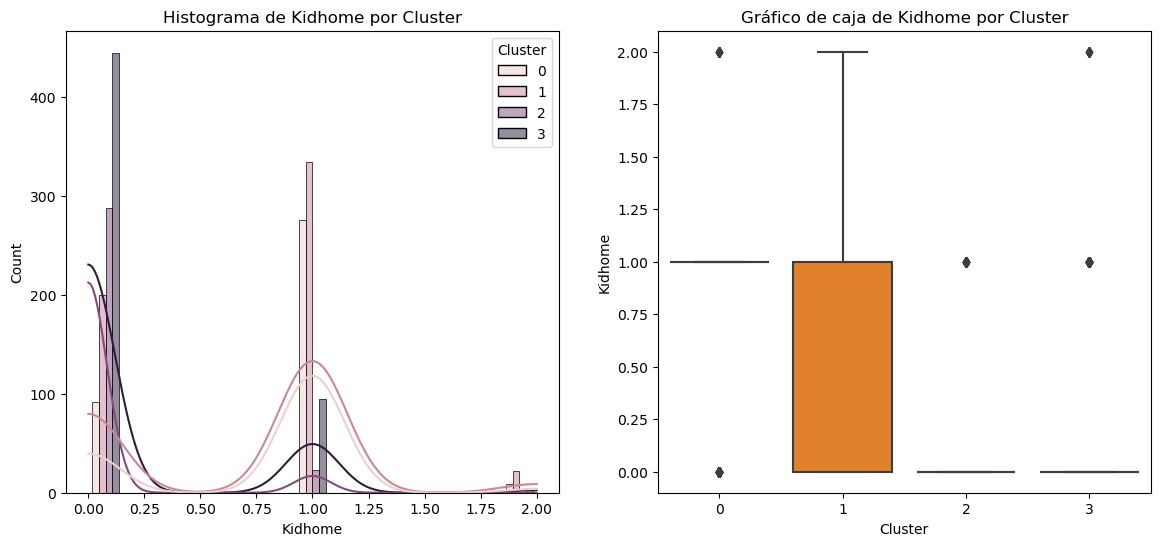

Estadísticos de resumen para Kidhome por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        377.0  0.78  0.47  0.0  1.0  1.0  1.0  2.0
1        556.0  0.68  0.55  0.0  0.0  1.0  1.0  2.0
2        311.0  0.07  0.26  0.0  0.0  0.0  0.0  1.0
3        545.0  0.19  0.42  0.0  0.0  0.0  0.0  2.0

ANOVA para Kidhome:
Estadístico F: 246.05
p-valor: 0.000
La variable Kidhome está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de Teenhome vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

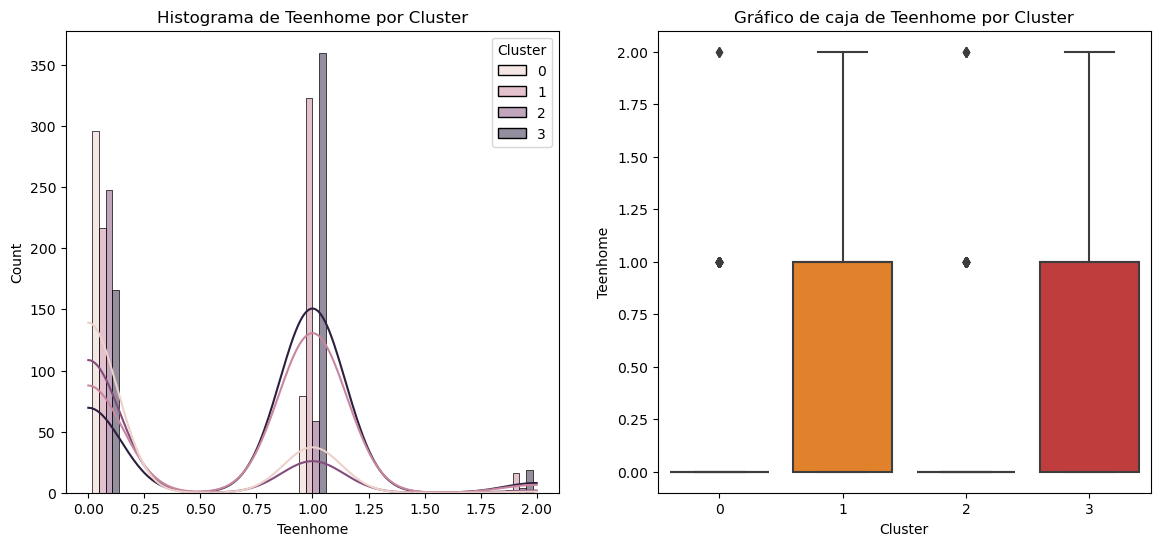

Estadísticos de resumen para Teenhome por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        377.0  0.22  0.43  0.0  0.0  0.0  0.0  2.0
1        556.0  0.64  0.54  0.0  0.0  1.0  1.0  2.0
2        311.0  0.22  0.44  0.0  0.0  0.0  0.0  2.0
3        545.0  0.73  0.52  0.0  0.0  1.0  1.0  2.0

ANOVA para Teenhome:
Estadístico F: 128.90
p-valor: 0.000
La variable Teenhome está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de Recency vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

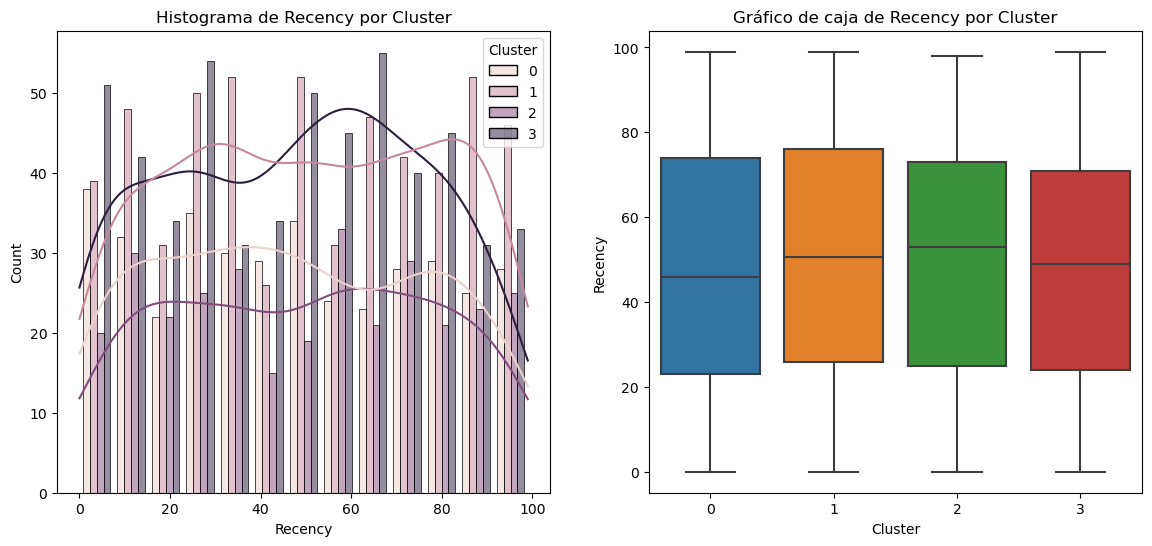

Estadísticos de resumen para Recency por Cluster:
         count   mean    std  min    25%   50%   75%   max
Cluster                                                   
0        377.0  47.31  29.05  0.0  23.00  46.0  74.0  99.0
1        556.0  50.31  29.05  0.0  25.75  50.5  76.0  99.0
2        311.0  49.52  28.53  0.0  25.00  53.0  73.0  98.0
3        545.0  47.83  28.34  0.0  24.00  49.0  71.0  99.0

ANOVA para Recency:
Estadístico F: 1.12
p-valor: 0.341
La variable Recency no está significativamente asociada con Cluster (p >= 0.05).

Análisis de MntWines vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

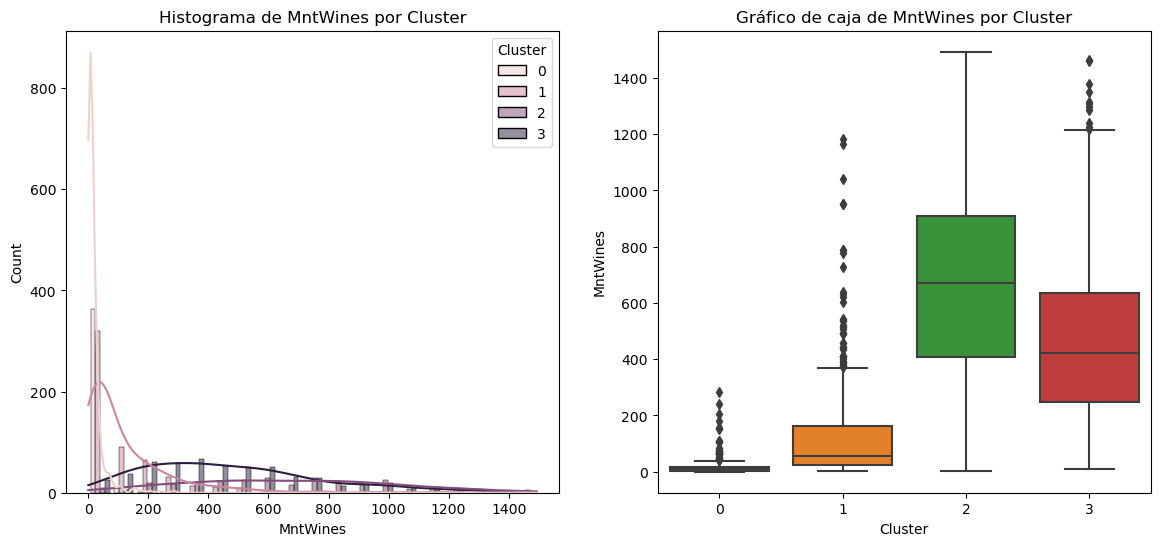

Estadísticos de resumen para MntWines por Cluster:
         count    mean     std  min    25%    50%    75%     max
Cluster                                                         
0        377.0   17.81   30.92  0.0    4.0    9.0   18.0   284.0
1        556.0  120.92  162.01  2.0   23.0   56.0  161.5  1181.0
2        311.0  667.19  344.37  1.0  408.5  670.0  909.0  1493.0
3        545.0  479.61  296.51  8.0  247.0  422.0  635.0  1462.0

ANOVA para MntWines:
Estadístico F: 641.79
p-valor: 0.000
La variable MntWines está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de MntFruits vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

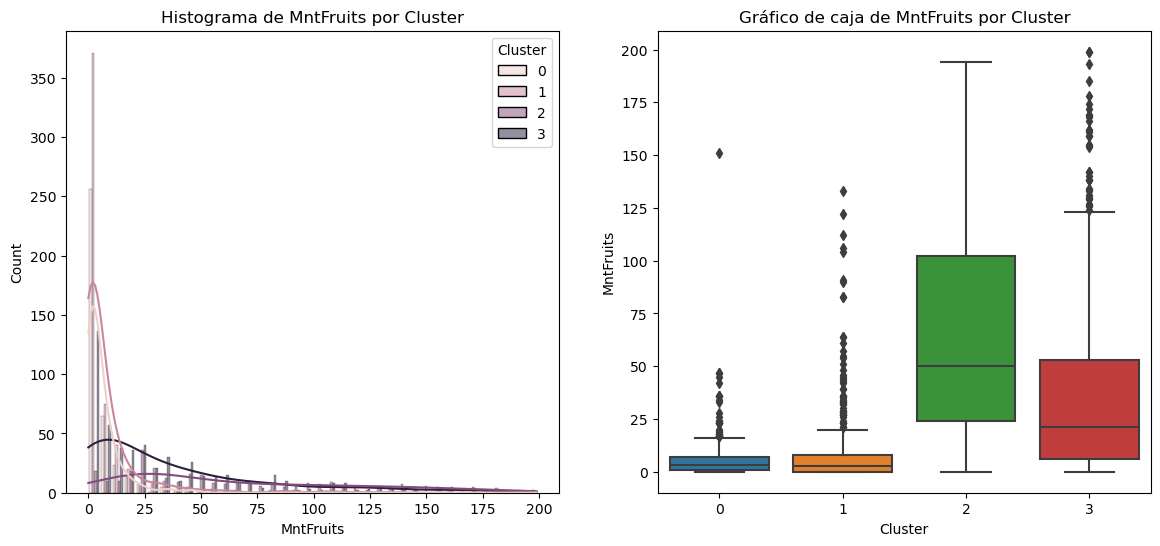

Estadísticos de resumen para MntFruits por Cluster:
         count   mean    std  min   25%   50%    75%    max
Cluster                                                    
0        377.0   5.86  10.64  0.0   1.0   3.0    7.0  151.0
1        556.0   7.94  16.05  0.0   0.0   2.5    8.0  133.0
2        311.0  65.50  51.32  0.0  24.0  50.0  102.0  194.0
3        545.0  36.84  42.78  0.0   6.0  21.0   53.0  199.0

ANOVA para MntFruits:
Estadístico F: 263.12
p-valor: 0.000
La variable MntFruits está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de MntMeatProducts vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

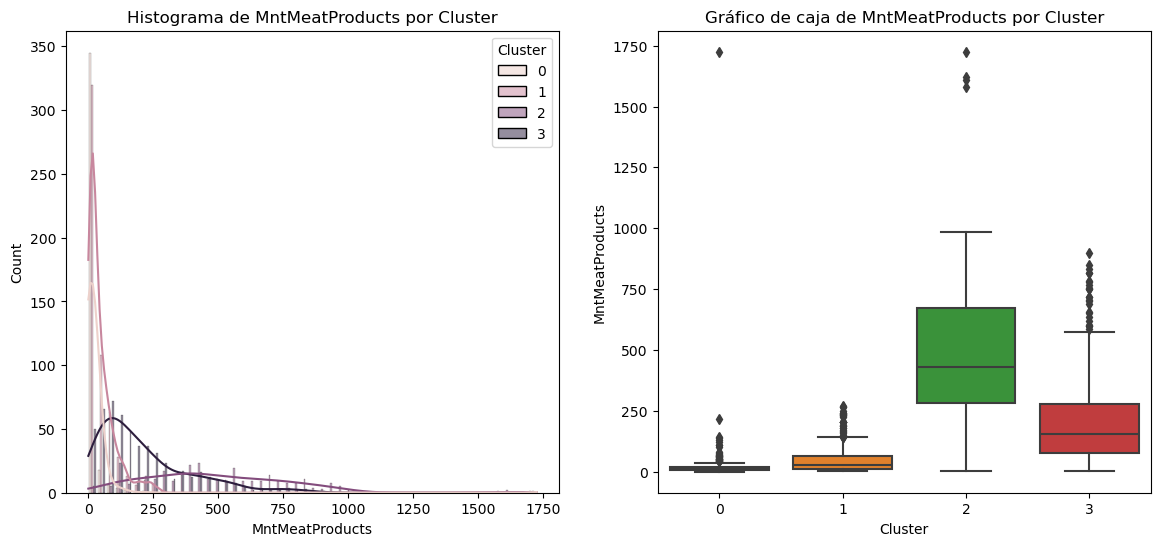

Estadísticos de resumen para MntMeatProducts por Cluster:
         count    mean     std  min    25%    50%    75%     max
Cluster                                                         
0        377.0   21.57   90.73  0.0    6.0   11.0   19.0  1725.0
1        556.0   46.02   51.31  1.0   11.0   26.0   63.0   271.0
2        311.0  482.94  276.21  1.0  281.5  431.0  672.5  1725.0
3        545.0  207.32  177.33  4.0   76.0  154.0  279.0   899.0

ANOVA para MntMeatProducts:
Estadístico F: 630.79
p-valor: 0.000
La variable MntMeatProducts está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de MntFishProducts vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

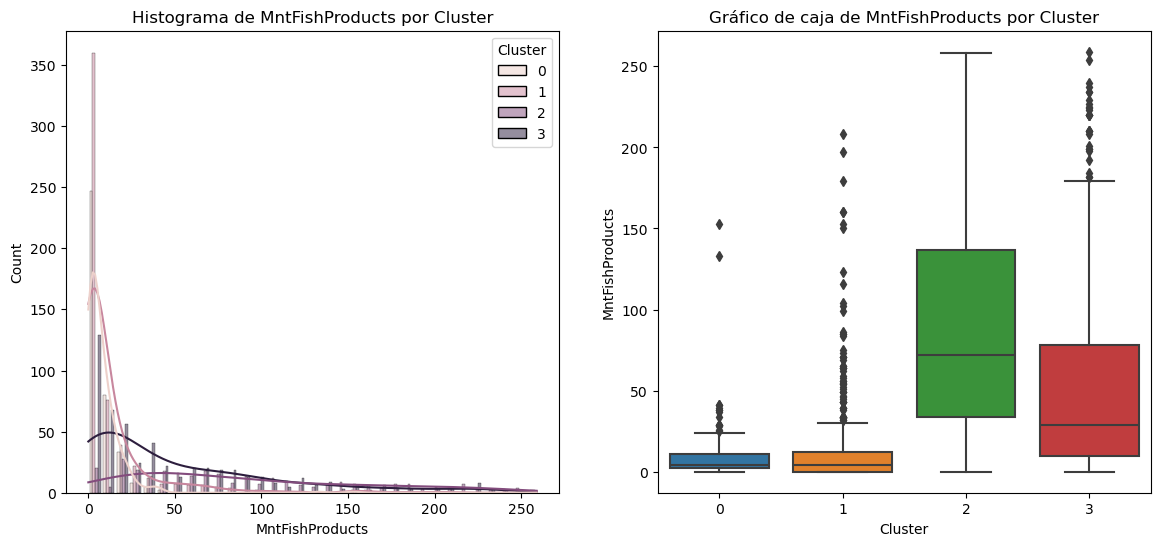

Estadísticos de resumen para MntFishProducts por Cluster:
         count   mean    std  min   25%   50%     75%    max
Cluster                                                     
0        377.0   7.81  12.61  0.0   2.0   4.0   11.00  153.0
1        556.0  12.97  25.72  0.0   0.0   4.0   12.25  208.0
2        311.0  89.96  67.44  0.0  33.5  72.0  137.00  258.0
3        545.0  51.14  57.62  0.0  10.0  29.0   78.00  259.0

ANOVA para MntFishProducts:
Estadístico F: 265.15
p-valor: 0.000
La variable MntFishProducts está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de MntSweetProducts vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

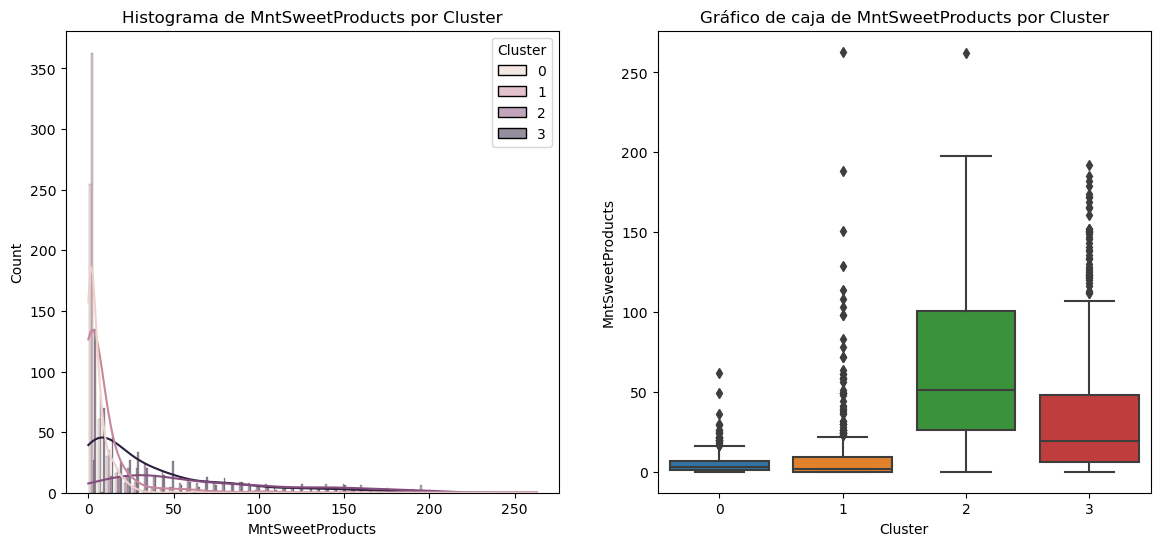

Estadísticos de resumen para MntSweetProducts por Cluster:
         count   mean    std  min   25%   50%    75%    max
Cluster                                                    
0        377.0   5.41   7.08  0.0   1.0   3.0    7.0   62.0
1        556.0   9.25  21.71  0.0   0.0   2.0    9.0  263.0
2        311.0  67.40  54.16  0.0  26.0  51.0  100.5  262.0
3        545.0  35.48  41.93  0.0   6.0  19.0   48.0  192.0

ANOVA para MntSweetProducts:
Estadístico F: 248.76
p-valor: 0.000
La variable MntSweetProducts está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de MntGoldProds vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

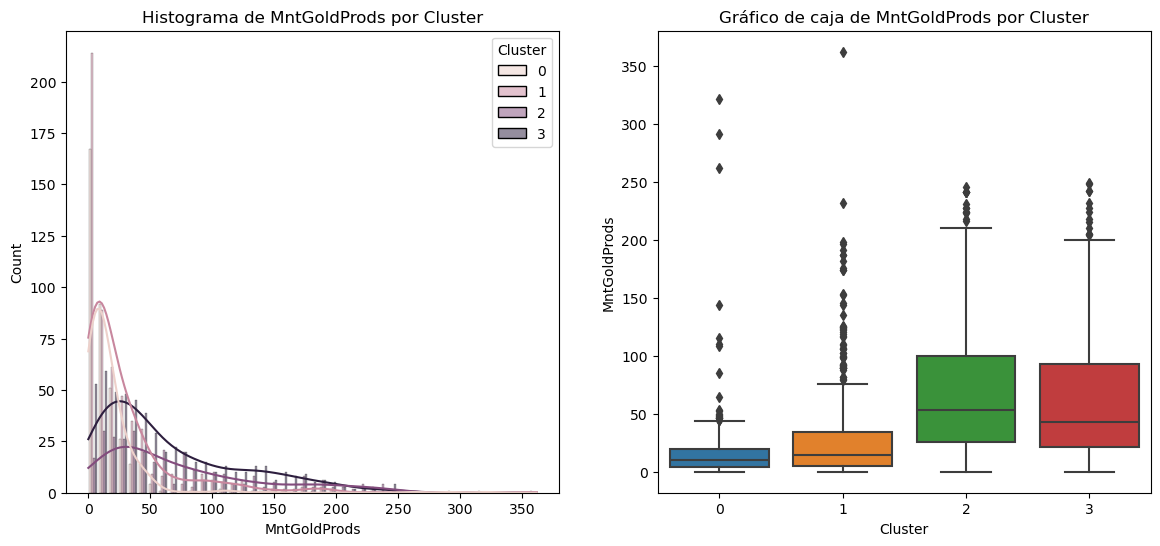

Estadísticos de resumen para MntGoldProds por Cluster:
         count   mean    std  min   25%   50%    75%    max
Cluster                                                    
0        377.0  16.72  29.83  0.0   4.0  10.0   20.0  321.0
1        556.0  27.71  38.95  0.0   5.0  14.0   34.0  362.0
2        311.0  71.84  61.46  0.0  26.0  53.0  100.0  245.0
3        545.0  63.68  56.31  0.0  21.0  43.0   93.0  249.0

ANOVA para MntGoldProds:
Estadístico F: 128.61
p-valor: 0.000
La variable MntGoldProds está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de NumDealsPurchases vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

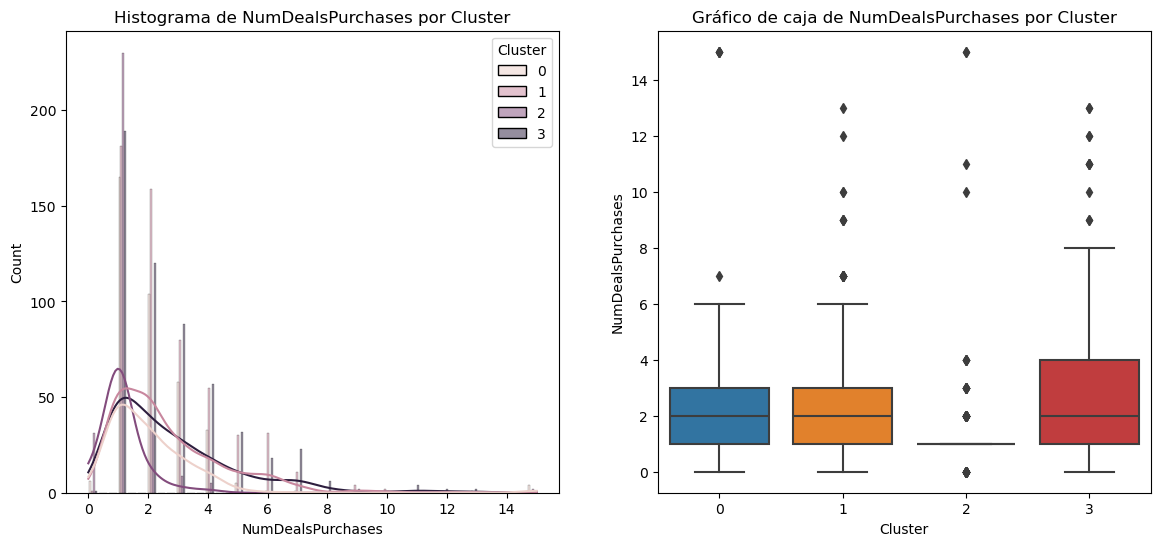

Estadísticos de resumen para NumDealsPurchases por Cluster:
         count  mean   std  min  25%  50%  75%   max
Cluster                                             
0        377.0  2.06  1.74  0.0  1.0  2.0  3.0  15.0
1        556.0  2.61  1.83  0.0  1.0  2.0  3.0  13.0
2        311.0  1.26  1.50  0.0  1.0  1.0  1.0  15.0
3        545.0  2.79  2.13  0.0  1.0  2.0  4.0  13.0

ANOVA para NumDealsPurchases:
Estadístico F: 52.34
p-valor: 0.000
La variable NumDealsPurchases está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de NumWebPurchases vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

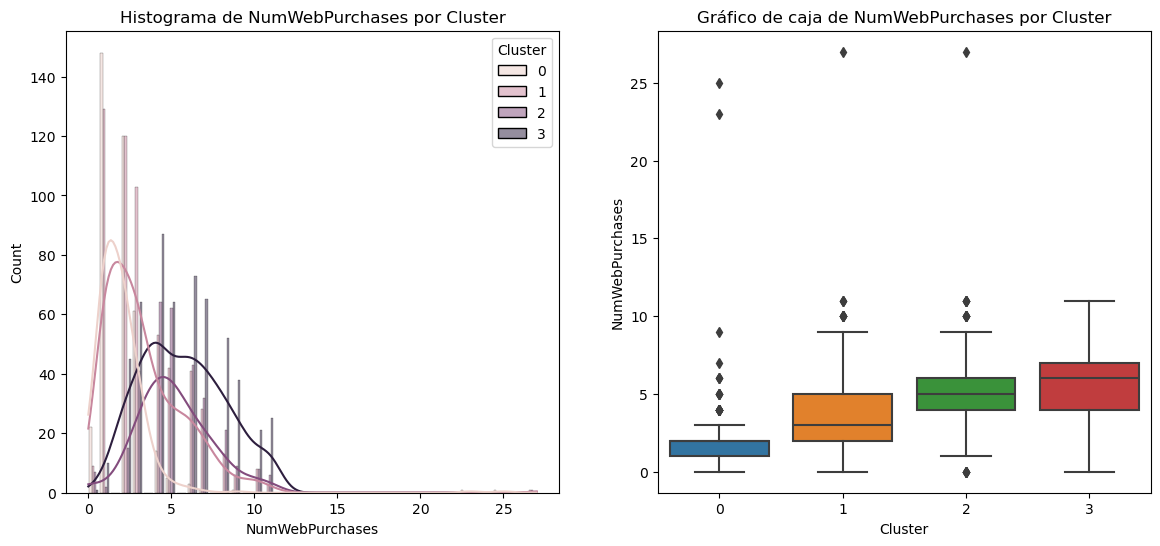

Estadísticos de resumen para NumWebPurchases por Cluster:
         count  mean   std  min  25%  50%  75%   max
Cluster                                             
0        377.0  1.95  1.99  0.0  1.0  2.0  2.0  25.0
1        556.0  3.31  2.48  0.0  2.0  3.0  5.0  27.0
2        311.0  5.23  2.51  0.0  4.0  5.0  6.0  27.0
3        545.0  5.68  2.54  0.0  4.0  6.0  7.0  11.0

ANOVA para NumWebPurchases:
Estadístico F: 221.01
p-valor: 0.000
La variable NumWebPurchases está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de NumCatalogPurchases vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

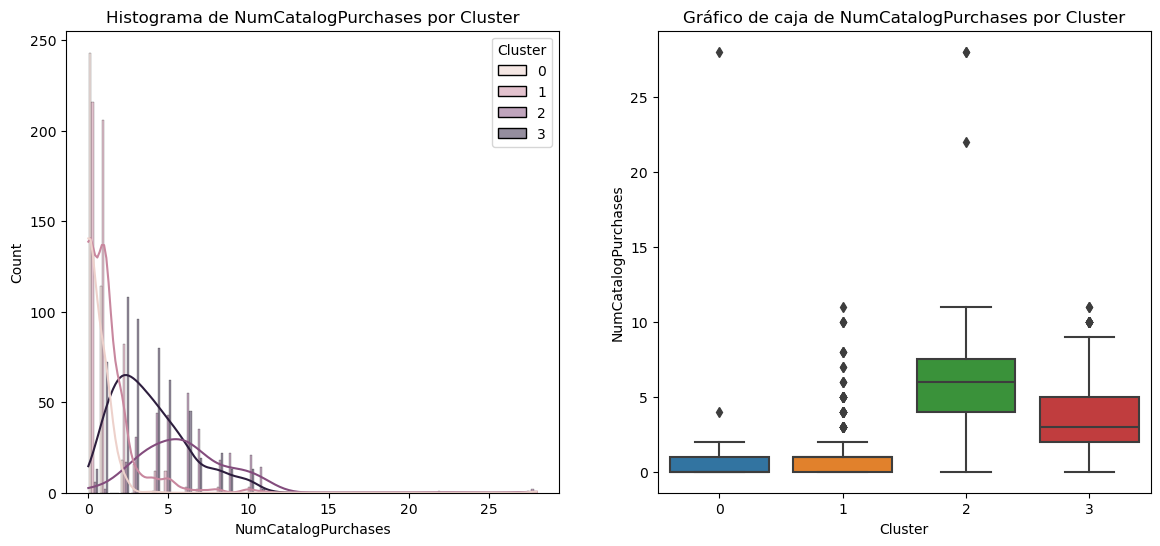

Estadísticos de resumen para NumCatalogPurchases por Cluster:
         count  mean   std  min  25%  50%  75%   max
Cluster                                             
0        377.0  0.48  1.55  0.0  0.0  0.0  1.0  28.0
1        556.0  1.12  1.53  0.0  0.0  1.0  1.0  11.0
2        311.0  6.04  3.24  0.0  4.0  6.0  7.5  28.0
3        545.0  3.77  2.35  0.0  2.0  3.0  5.0  11.0

ANOVA para NumCatalogPurchases:
Estadístico F: 516.21
p-valor: 0.000
La variable NumCatalogPurchases está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de NumStorePurchases vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

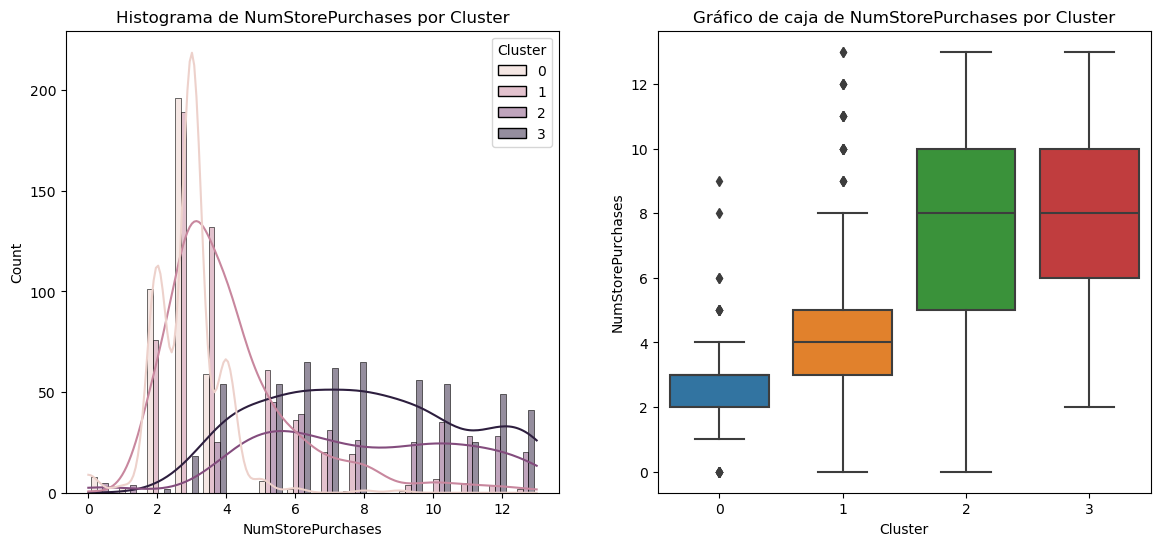

Estadísticos de resumen para NumStorePurchases por Cluster:
         count  mean   std  min  25%  50%   75%   max
Cluster                                              
0        377.0  2.89  0.95  0.0  2.0  3.0   3.0   9.0
1        556.0  4.13  1.99  0.0  3.0  4.0   5.0  13.0
2        311.0  7.93  3.04  0.0  5.0  8.0  10.0  13.0
3        545.0  7.94  2.88  2.0  6.0  8.0  10.0  13.0

ANOVA para NumStorePurchases:
Estadístico F: 518.90
p-valor: 0.000
La variable NumStorePurchases está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de NumWebVisitsMonth vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

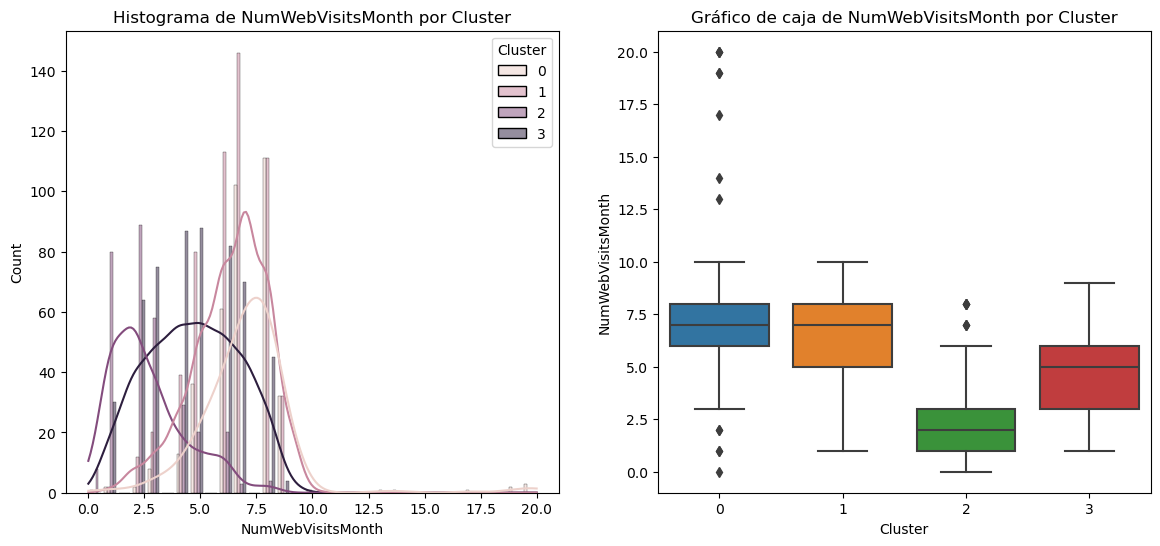

Estadísticos de resumen para NumWebVisitsMonth por Cluster:
         count  mean   std  min  25%  50%  75%   max
Cluster                                             
0        377.0  7.08  2.22  0.0  6.0  7.0  8.0  20.0
1        556.0  6.35  1.64  1.0  5.0  7.0  8.0  10.0
2        311.0  2.64  1.68  0.0  1.0  2.0  3.0   8.0
3        545.0  4.68  2.02  1.0  3.0  5.0  6.0   9.0

ANOVA para NumWebVisitsMonth:
Estadístico F: 390.04
p-valor: 0.000
La variable NumWebVisitsMonth está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de AcceptedCmp3 vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

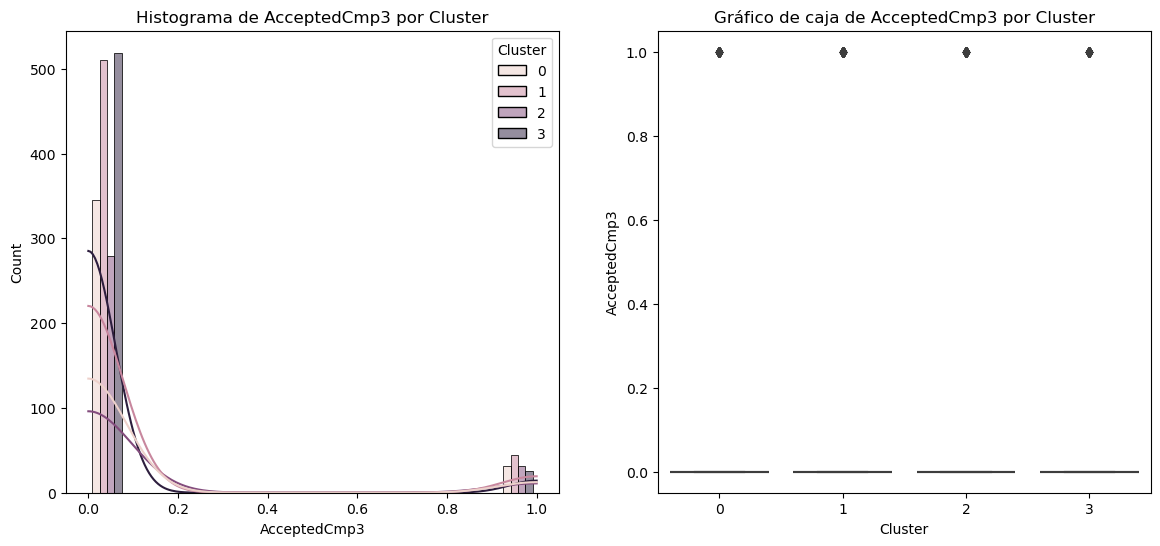

Estadísticos de resumen para AcceptedCmp3 por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        377.0  0.08  0.28  0.0  0.0  0.0  0.0  1.0
1        556.0  0.08  0.27  0.0  0.0  0.0  0.0  1.0
2        311.0  0.10  0.30  0.0  0.0  0.0  0.0  1.0
3        545.0  0.05  0.21  0.0  0.0  0.0  0.0  1.0

ANOVA para AcceptedCmp3:
Estadístico F: 3.38
p-valor: 0.018
La variable AcceptedCmp3 está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de AcceptedCmp4 vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

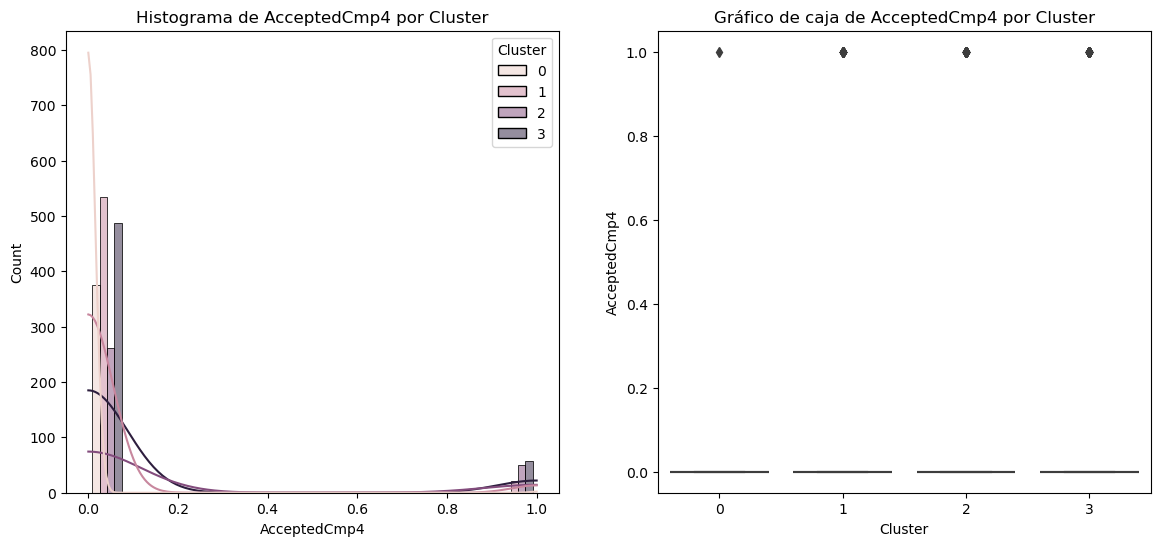

Estadísticos de resumen para AcceptedCmp4 por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        377.0  0.00  0.05  0.0  0.0  0.0  0.0  1.0
1        556.0  0.04  0.20  0.0  0.0  0.0  0.0  1.0
2        311.0  0.16  0.37  0.0  0.0  0.0  0.0  1.0
3        545.0  0.11  0.31  0.0  0.0  0.0  0.0  1.0

ANOVA para AcceptedCmp4:
Estadístico F: 28.19
p-valor: 0.000
La variable AcceptedCmp4 está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de AcceptedCmp5 vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

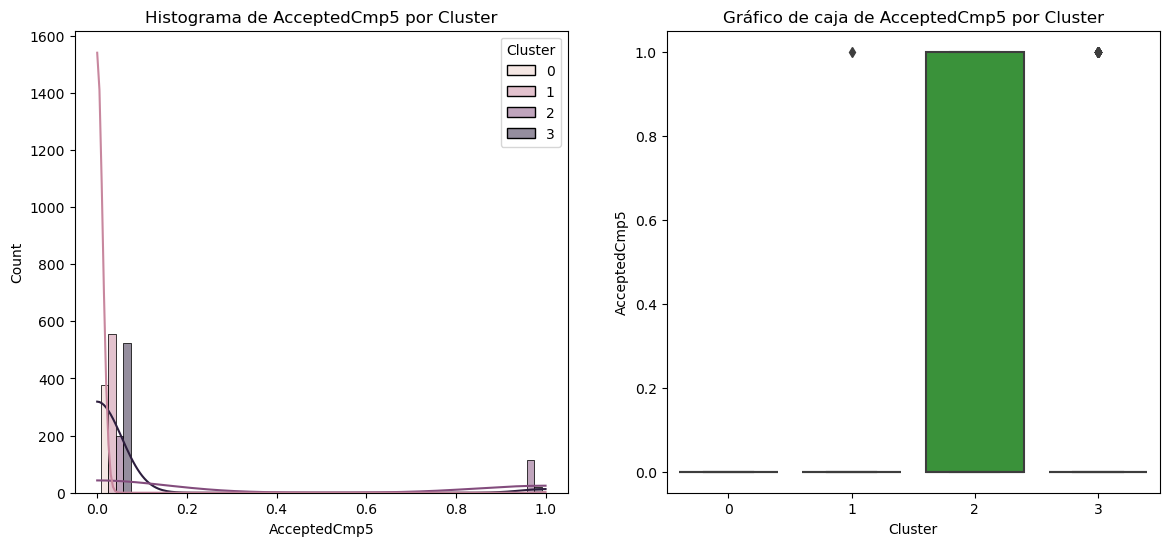

Estadísticos de resumen para AcceptedCmp5 por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        377.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0
1        556.0  0.00  0.04  0.0  0.0  0.0  0.0  1.0
2        311.0  0.36  0.48  0.0  0.0  0.0  1.0  1.0
3        545.0  0.04  0.19  0.0  0.0  0.0  0.0  1.0

ANOVA para AcceptedCmp5:
Estadístico F: 202.41
p-valor: 0.000
La variable AcceptedCmp5 está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de AcceptedCmp1 vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

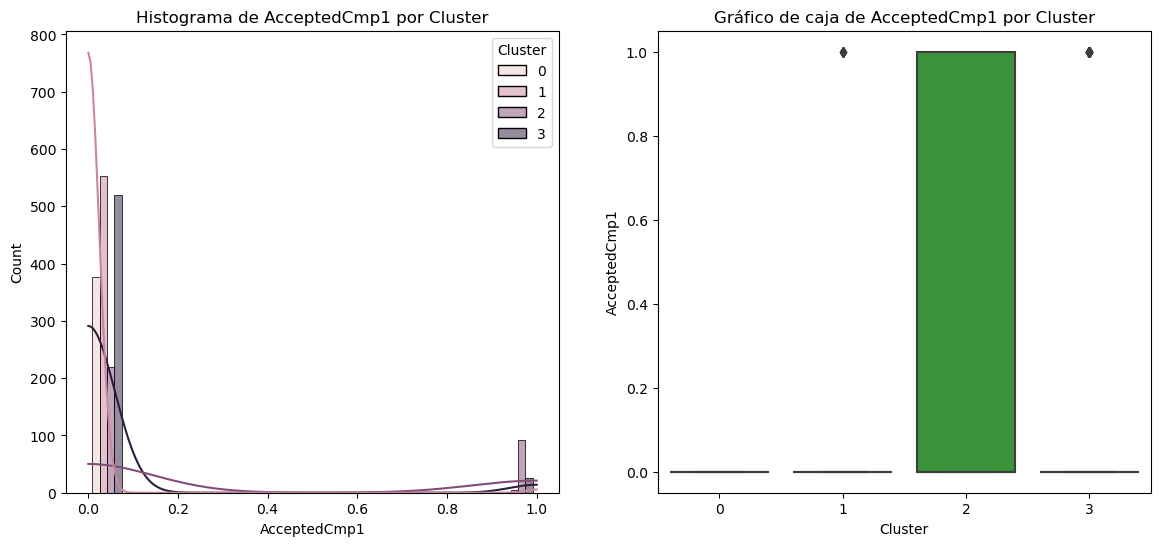

Estadísticos de resumen para AcceptedCmp1 por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        377.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0
1        556.0  0.01  0.08  0.0  0.0  0.0  0.0  1.0
2        311.0  0.30  0.46  0.0  0.0  0.0  1.0  1.0
3        545.0  0.05  0.21  0.0  0.0  0.0  0.0  1.0

ANOVA para AcceptedCmp1:
Estadístico F: 129.83
p-valor: 0.000
La variable AcceptedCmp1 está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de AcceptedCmp2 vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

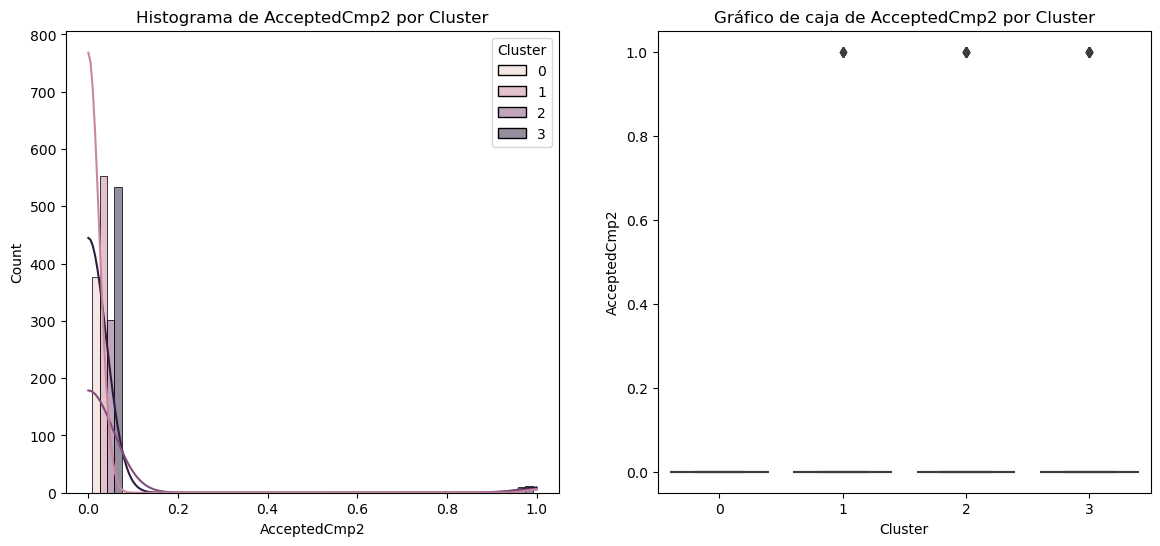

Estadísticos de resumen para AcceptedCmp2 por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        377.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0
1        556.0  0.01  0.08  0.0  0.0  0.0  0.0  1.0
2        311.0  0.03  0.18  0.0  0.0  0.0  0.0  1.0
3        545.0  0.02  0.14  0.0  0.0  0.0  0.0  1.0

ANOVA para AcceptedCmp2:
Estadístico F: 5.43
p-valor: 0.001
La variable AcceptedCmp2 está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de Complain vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

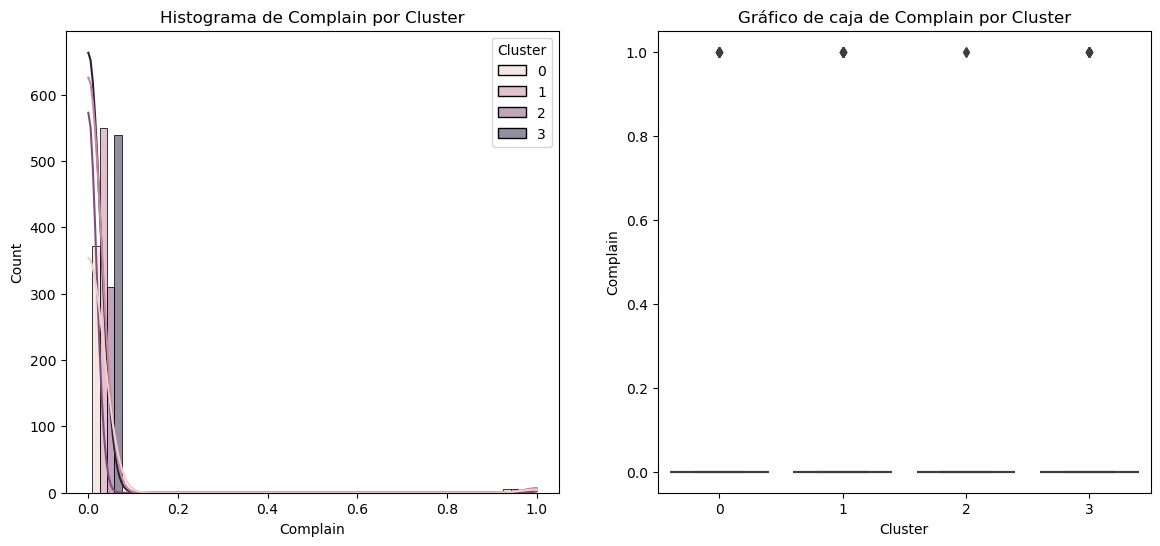

Estadísticos de resumen para Complain por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        377.0  0.01  0.11  0.0  0.0  0.0  0.0  1.0
1        556.0  0.01  0.10  0.0  0.0  0.0  0.0  1.0
2        311.0  0.00  0.06  0.0  0.0  0.0  0.0  1.0
3        545.0  0.01  0.10  0.0  0.0  0.0  0.0  1.0

ANOVA para Complain:
Estadístico F: 0.66
p-valor: 0.578
La variable Complain no está significativamente asociada con Cluster (p >= 0.05).

Análisis de Response vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

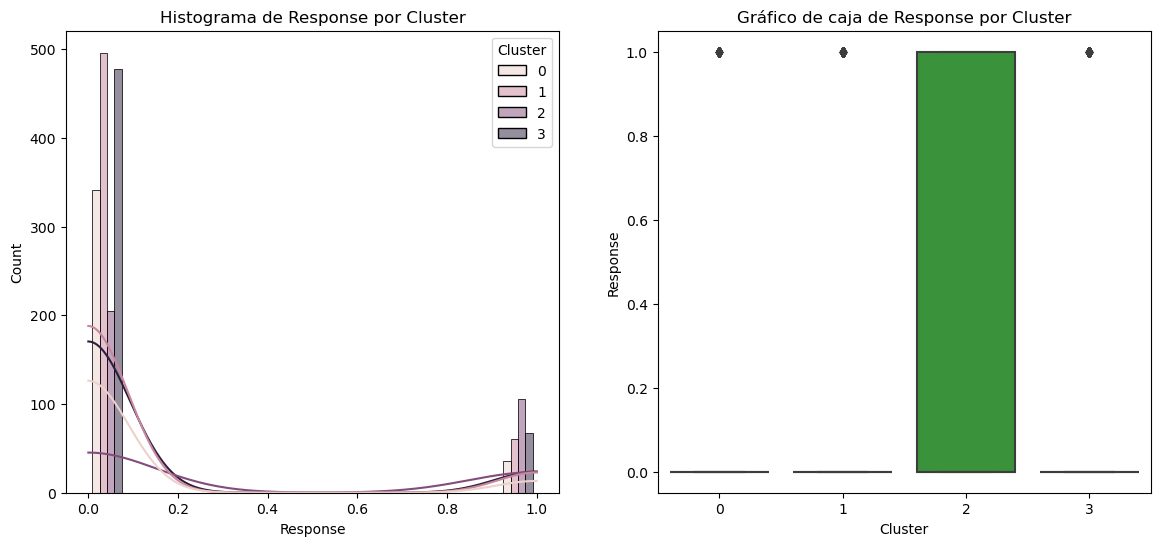

Estadísticos de resumen para Response por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        377.0  0.10  0.29  0.0  0.0  0.0  0.0  1.0
1        556.0  0.11  0.31  0.0  0.0  0.0  0.0  1.0
2        311.0  0.34  0.47  0.0  0.0  0.0  1.0  1.0
3        545.0  0.12  0.33  0.0  0.0  0.0  0.0  1.0

ANOVA para Response:
Estadístico F: 38.32
p-valor: 0.000
La variable Response está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de age vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

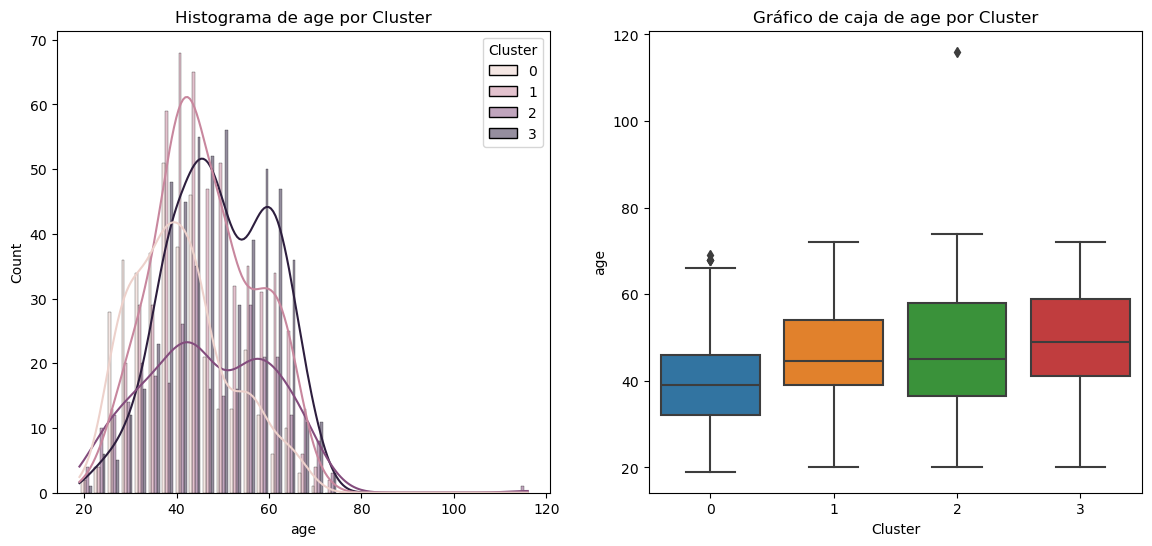

Estadísticos de resumen para age por Cluster:
         count   mean    std   min   25%   50%   75%    max
Cluster                                                    
0        377.0  40.79  10.58  19.0  32.0  39.0  46.0   69.0
1        556.0  46.11  10.83  20.0  39.0  44.5  54.0   72.0
2        311.0  47.00  13.83  20.0  36.5  45.0  58.0  116.0
3        545.0  49.46  11.01  20.0  41.0  49.0  59.0   72.0

ANOVA para age:
Estadístico F: 43.62
p-valor: 0.000
La variable age está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de customes_seniority vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

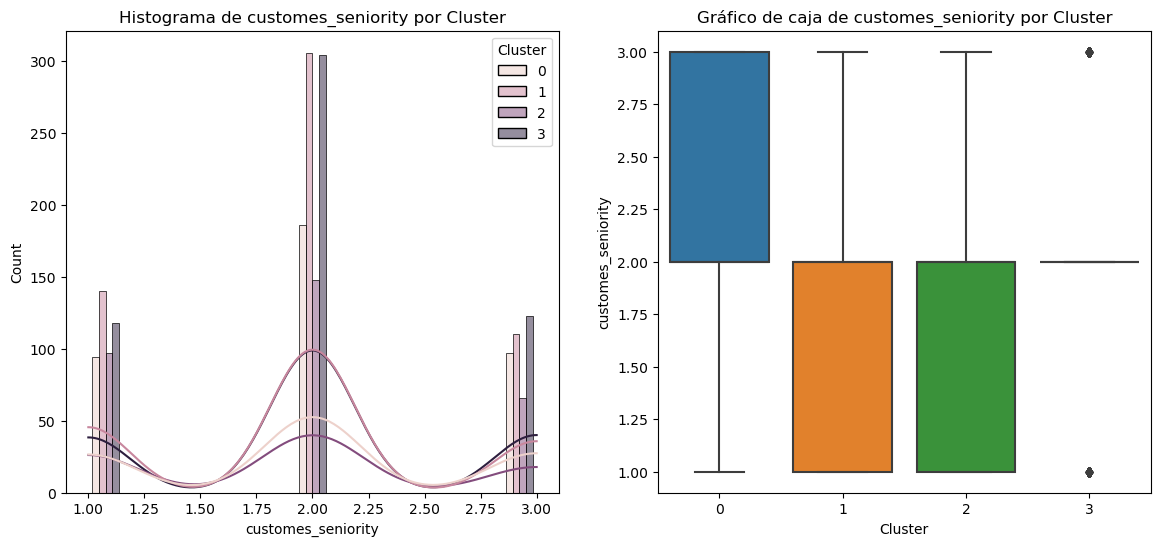

Estadísticos de resumen para customes_seniority por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        377.0  2.01  0.71  1.0  2.0  2.0  3.0  3.0
1        556.0  1.95  0.67  1.0  1.0  2.0  2.0  3.0
2        311.0  1.90  0.72  1.0  1.0  2.0  2.0  3.0
3        545.0  2.01  0.67  1.0  2.0  2.0  2.0  3.0

ANOVA para customes_seniority:
Estadístico F: 2.27
p-valor: 0.078
La variable customes_seniority no está significativamente asociada con Cluster (p >= 0.05).

Análisis de Household_members vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

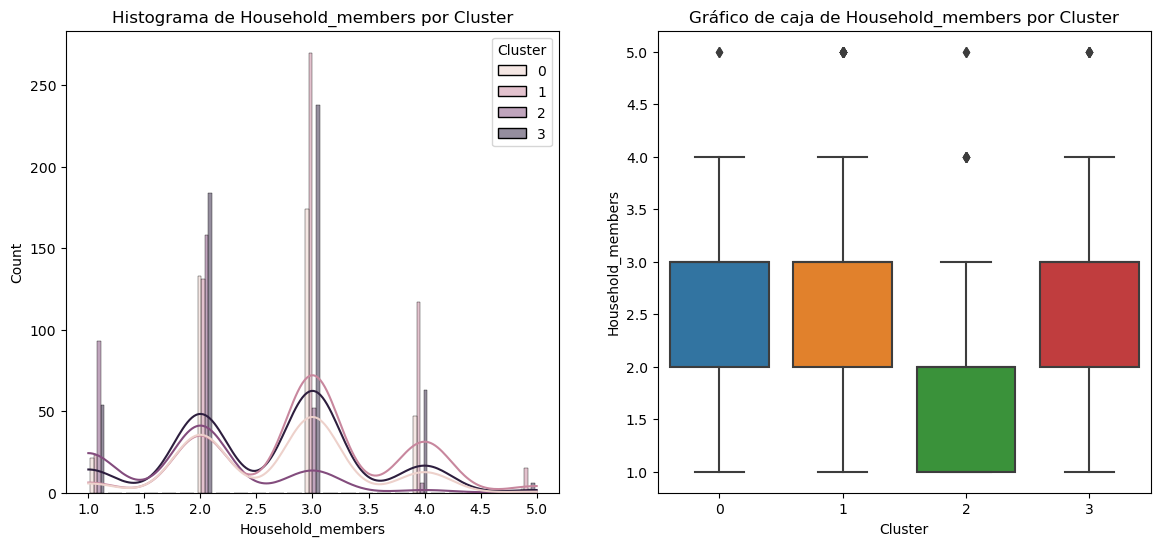

Estadísticos de resumen para Household_members por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        377.0  2.67  0.78  1.0  2.0  3.0  3.0  5.0
1        556.0  2.95  0.85  1.0  2.0  3.0  3.0  5.0
2        311.0  1.93  0.77  1.0  1.0  2.0  2.0  5.0
3        545.0  2.60  0.86  1.0  2.0  3.0  3.0  5.0

ANOVA para Household_members:
Estadístico F: 102.64
p-valor: 0.000
La variable Household_members está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de Total_amount vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

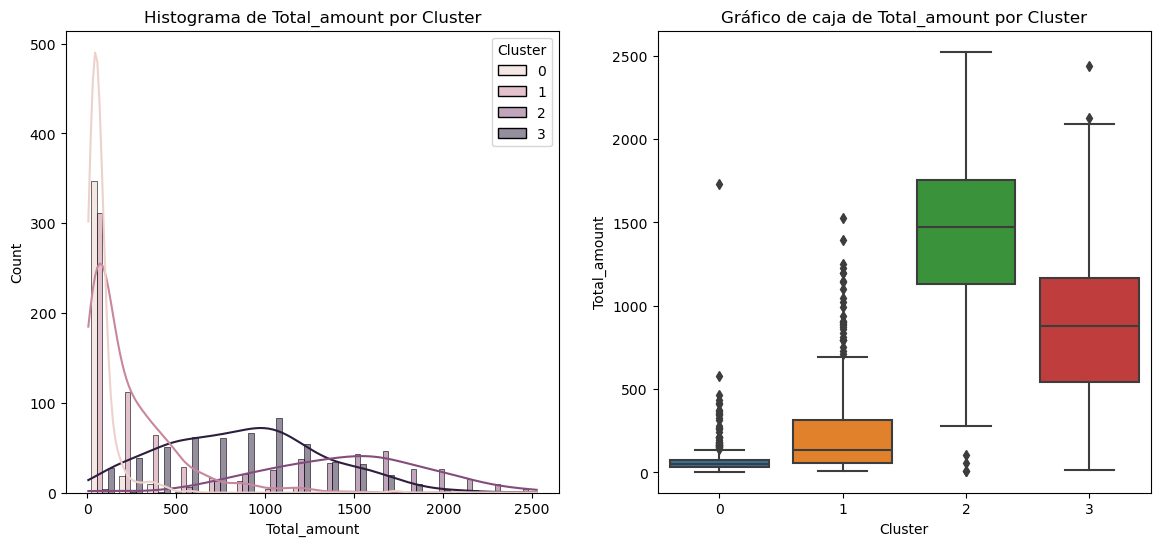

Estadísticos de resumen para Total_amount por Cluster:
         count     mean     std   min     25%     50%      75%     max
Cluster                                                               
0        377.0    75.19  113.68   5.0    32.0    50.0    76.00  1730.0
1        556.0   224.81  243.59   8.0    55.0   132.5   316.25  1526.0
2        311.0  1444.83  465.96   6.0  1130.5  1472.0  1753.50  2525.0
3        545.0   874.08  446.23  16.0   542.0   879.0  1169.00  2440.0

ANOVA para Total_amount:
Estadístico F: 1240.62
p-valor: 0.000
La variable Total_amount está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de Total_purchase vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

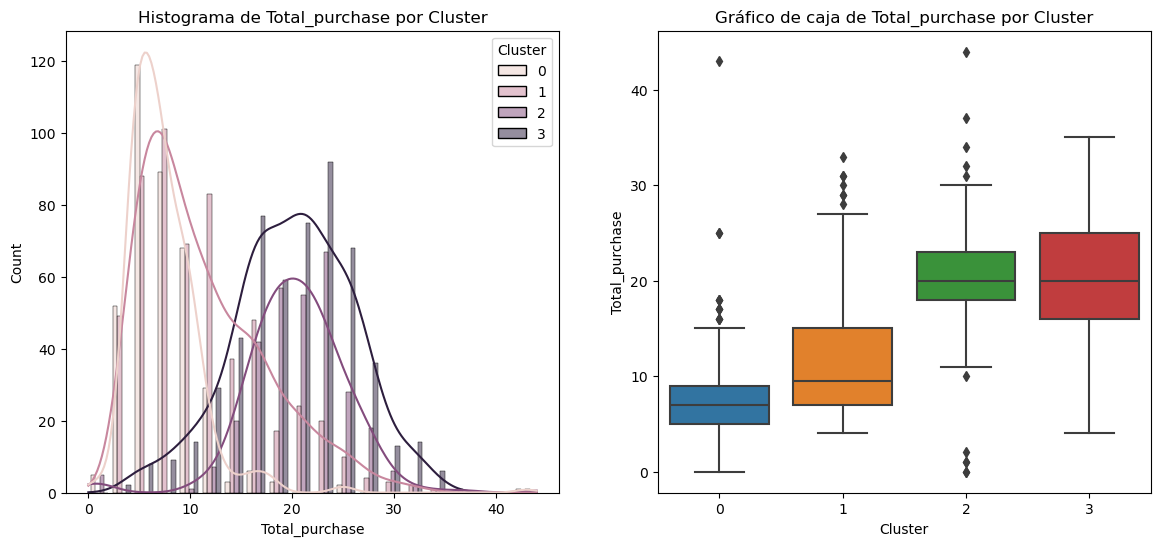

Estadísticos de resumen para Total_purchase por Cluster:
         count   mean   std  min   25%   50%   75%   max
Cluster                                                 
0        377.0   7.38  3.65  0.0   5.0   7.0   9.0  43.0
1        556.0  11.17  6.02  4.0   7.0   9.5  15.0  33.0
2        311.0  20.46  5.03  0.0  18.0  20.0  23.0  44.0
3        545.0  20.18  5.80  4.0  16.0  20.0  25.0  35.0

ANOVA para Total_purchase:
Estadístico F: 624.64
p-valor: 0.000
La variable Total_purchase está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de Total_cmp vs Cluster
****************************************


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupin

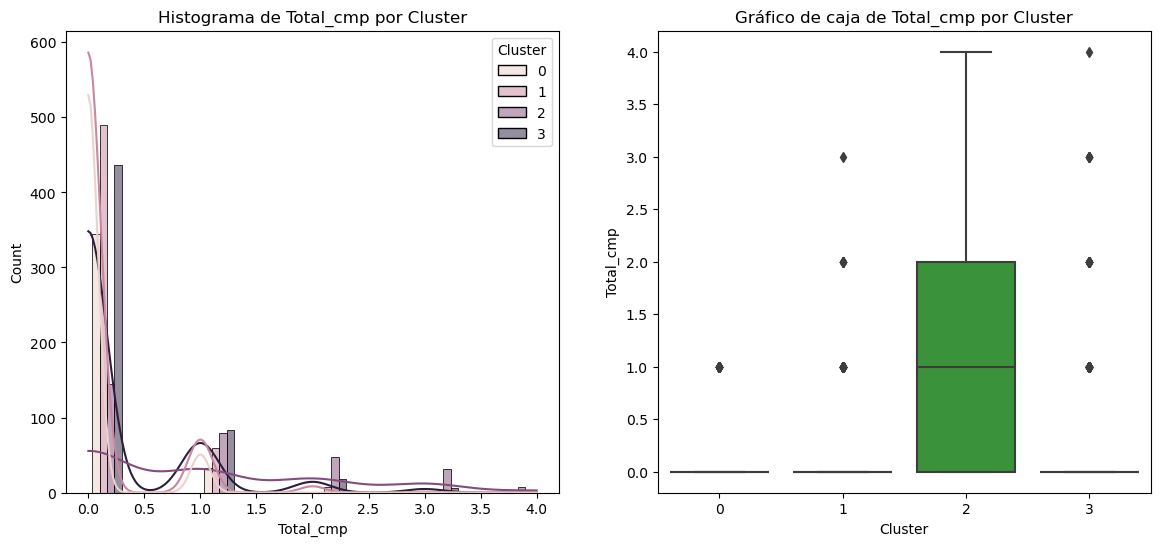

Estadísticos de resumen para Total_cmp por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        377.0  0.09  0.28  0.0  0.0  0.0  0.0  1.0
1        556.0  0.14  0.39  0.0  0.0  0.0  0.0  3.0
2        311.0  0.95  1.11  0.0  0.0  1.0  2.0  4.0
3        545.0  0.26  0.59  0.0  0.0  0.0  0.0  4.0

ANOVA para Total_cmp:
Estadístico F: 144.60
p-valor: 0.000
La variable Total_cmp está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Las features correlacionadas son: ['Income', 'Kidhome', 'Teenhome', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response', 'age', 'Household_members', 'Total_amount', 'Total_purchase', 'Total_cmp']
Las features NO correlaci

In [13]:
target = 'Cluster'

analisis_bivariable_numericas_categorica(train_set,target,features_num)

### Análisis con las variables categóricas

Análisis de Education vs Cluster
****************************************


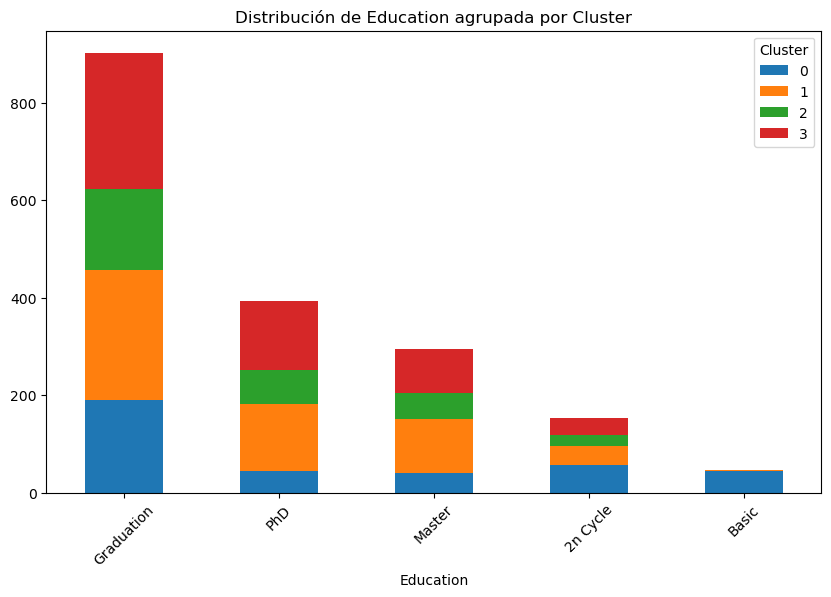

Tabla de contingencia de Education vs Cluster:
Cluster       0    1    2    3
Education                     
Graduation  190  268  166  279
PhD          45  136   71  141
Master       40  112   52   90
2n Cycle     57   39   22   35
Basic        45    1    0    0

Tabla de porcentajes de Education respecto a Cluster:
Cluster             0          1          2          3
Education                                             
Graduation  50.397878  48.201439  53.376206  51.192661
PhD         11.936340  24.460432  22.829582  25.871560
Master      10.610080  20.143885  16.720257  16.513761
2n Cycle    15.119363   7.014388   7.073955   6.422018
Basic       11.936340   0.179856   0.000000   0.000000

Tabla de frecuencias para Education:
            Frecuencia Absoluta  Frecuencia Relativa (%)
Education                                               
Graduation                  903                50.475126
PhD                         393                21.967580
Master                      29

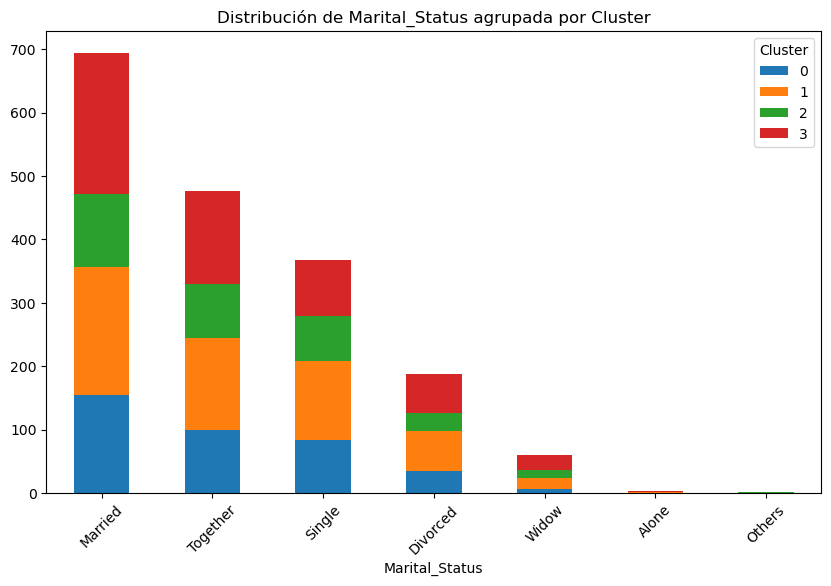

Tabla de contingencia de Marital_Status vs Cluster:
Cluster           0    1    2    3
Marital_Status                    
Married         154  203  114  223
Together         99  146   84  147
Single           84  124   71   88
Divorced         34   64   28   61
Widow             6   17   13   24
Alone             0    2    0    1
Others            0    0    1    1

Tabla de porcentajes de Marital_Status respecto a Cluster:
Cluster                 0          1          2          3
Marital_Status                                            
Married         40.848806  36.510791  36.655949  40.917431
Together        26.259947  26.258993  27.009646  26.972477
Single          22.281167  22.302158  22.829582  16.146789
Divorced         9.018568  11.510791   9.003215  11.192661
Widow            1.591512   3.057554   4.180064   4.403670
Alone            0.000000   0.359712   0.000000   0.183486
Others           0.000000   0.000000   0.321543   0.183486

Tabla de frecuencias para Marital_Status:

In [14]:
analisis_bivariable_categoricas_categorica(train_set,target,features_cat)

### Otros análisis

In [15]:
cluster_0 = train_set.loc[train_set['Cluster']==0]
cluster_0.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Income,377.0,23293.51,6968.09,1730.0,19329.0,24434.0,28764.0,32644.0
Kidhome,377.0,0.78,0.47,0.0,1.0,1.0,1.0,2.0
Teenhome,377.0,0.22,0.43,0.0,0.0,0.0,0.0,2.0
Recency,377.0,47.31,29.05,0.0,23.0,46.0,74.0,99.0
MntWines,377.0,17.81,30.92,0.0,4.0,9.0,18.0,284.0
MntFruits,377.0,5.86,10.64,0.0,1.0,3.0,7.0,151.0
MntMeatProducts,377.0,21.57,90.73,0.0,6.0,11.0,19.0,1725.0
MntFishProducts,377.0,7.81,12.61,0.0,2.0,4.0,11.0,153.0
MntSweetProducts,377.0,5.41,7.08,0.0,1.0,3.0,7.0,62.0
MntGoldProds,377.0,16.72,29.83,0.0,4.0,10.0,20.0,321.0


In [16]:
cluster_0['Marital_Status'].value_counts(normalize=True).round(2)

Marital_Status
Married     0.41
Together    0.26
Single      0.22
Divorced    0.09
Widow       0.02
Alone       0.00
Others      0.00
Name: proportion, dtype: float64

In [17]:
cluster_0['Education'].value_counts(normalize=True).round(2)

Education
Graduation    0.50
2n Cycle      0.15
Basic         0.12
PhD           0.12
Master        0.11
Name: proportion, dtype: float64

In [18]:
cluster_1 = train_set.loc[train_set['Cluster']==1]
cluster_1.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Income,556.0,42227.87,5767.94,32871.0,37055.16,42057.0,46894.25,52614.0
Kidhome,556.0,0.68,0.55,0.0,0.00,1.0,1.00,2.0
Teenhome,556.0,0.64,0.54,0.0,0.00,1.0,1.00,2.0
Recency,556.0,50.31,29.05,0.0,25.75,50.5,76.00,99.0
MntWines,556.0,120.92,162.01,2.0,23.00,56.0,161.50,1181.0
MntFruits,556.0,7.94,16.05,0.0,0.00,2.5,8.00,133.0
MntMeatProducts,556.0,46.02,51.31,1.0,11.00,26.0,63.00,271.0
MntFishProducts,556.0,12.97,25.72,0.0,0.00,4.0,12.25,208.0
MntSweetProducts,556.0,9.25,21.71,0.0,0.00,2.0,9.00,263.0
MntGoldProds,556.0,27.71,38.95,0.0,5.00,14.0,34.00,362.0


In [19]:
cluster_1['Marital_Status'].value_counts(normalize=True).round(2)

Marital_Status
Married     0.37
Together    0.26
Single      0.22
Divorced    0.12
Widow       0.03
Alone       0.00
Others      0.00
Name: proportion, dtype: float64

In [20]:
cluster_1['Education'].value_counts(normalize=True).round(2)

Education
Graduation    0.48
PhD           0.24
Master        0.20
2n Cycle      0.07
Basic         0.00
Name: proportion, dtype: float64

In [21]:
cluster_2 = train_set.loc[train_set['Cluster']==2]
cluster_2.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Income,311.0,83401.43,12835.74,73356.0,77379.0,80695.0,84870.5,162397.0
Kidhome,311.0,0.07,0.26,0.0,0.0,0.0,0.0,1.0
Teenhome,311.0,0.22,0.44,0.0,0.0,0.0,0.0,2.0
Recency,311.0,49.52,28.53,0.0,25.0,53.0,73.0,98.0
MntWines,311.0,667.19,344.37,1.0,408.5,670.0,909.0,1493.0
MntFruits,311.0,65.50,51.32,0.0,24.0,50.0,102.0,194.0
MntMeatProducts,311.0,482.94,276.21,1.0,281.5,431.0,672.5,1725.0
MntFishProducts,311.0,89.96,67.44,0.0,33.5,72.0,137.0,258.0
MntSweetProducts,311.0,67.40,54.16,0.0,26.0,51.0,100.5,262.0
MntGoldProds,311.0,71.84,61.46,0.0,26.0,53.0,100.0,245.0


In [22]:
cluster_2['Marital_Status'].value_counts(normalize=True).round(2)

Marital_Status
Married     0.37
Together    0.27
Single      0.23
Divorced    0.09
Widow       0.04
Others      0.00
Alone       0.00
Name: proportion, dtype: float64

In [23]:
cluster_2['Education'].value_counts(normalize=True).round(2)

Education
Graduation    0.53
PhD           0.23
Master        0.17
2n Cycle      0.07
Basic         0.00
Name: proportion, dtype: float64

In [24]:
cluster_3 = train_set.loc[train_set['Cluster']==3]
cluster_3.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Income,545.0,63066.24,5882.96,52750.0,57954.0,63159.0,68118.0,73170.0
Kidhome,545.0,0.19,0.42,0.0,0.0,0.0,0.0,2.0
Teenhome,545.0,0.73,0.52,0.0,0.0,1.0,1.0,2.0
Recency,545.0,47.83,28.34,0.0,24.0,49.0,71.0,99.0
MntWines,545.0,479.61,296.51,8.0,247.0,422.0,635.0,1462.0
MntFruits,545.0,36.84,42.78,0.0,6.0,21.0,53.0,199.0
MntMeatProducts,545.0,207.32,177.33,4.0,76.0,154.0,279.0,899.0
MntFishProducts,545.0,51.14,57.62,0.0,10.0,29.0,78.0,259.0
MntSweetProducts,545.0,35.48,41.93,0.0,6.0,19.0,48.0,192.0
MntGoldProds,545.0,63.68,56.31,0.0,21.0,43.0,93.0,249.0


In [25]:
cluster_3['Marital_Status'].value_counts(normalize=True).round(2)

Marital_Status
Married     0.41
Together    0.27
Single      0.16
Divorced    0.11
Widow       0.04
Alone       0.00
Others      0.00
Name: proportion, dtype: float64

In [26]:
cluster_3['Education'].value_counts(normalize=True).round(2)

Education
Graduation    0.51
PhD           0.26
Master        0.17
2n Cycle      0.06
Basic         0.00
Name: proportion, dtype: float64

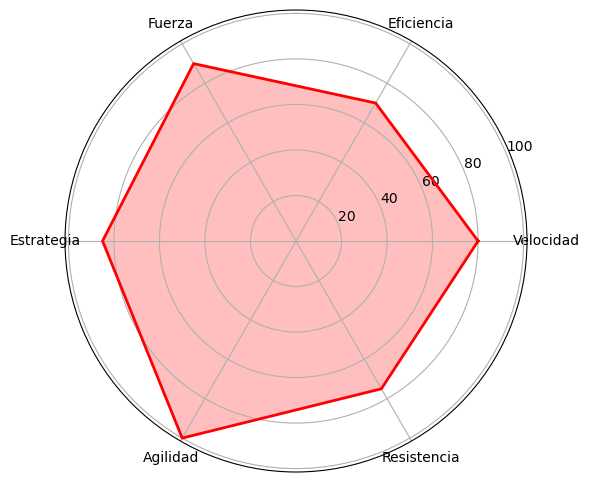

In [27]:
# Ejemplo gráfico de radar dado por chatGPT

# Número de variables que estamos graficando.
num_vars = 6

# Dividir el círculo y calcular los ángulos necesarios para representar cada eje.
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Los datos del gráfico de radar.
stats = [80, 70, 90, 85, 100, 75]

# El gráfico es circular, por lo que necesitamos cerrar el círculo y los ángulos deben completarse.
stats += stats[:1]
angles += angles[:1]

# Iniciar el gráfico de radar.
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Dibujar una línea alrededor del gráfico de radar.
ax.fill(angles, stats, color='red', alpha=0.25)

# Dibujar las líneas de los ejes.
ax.plot(angles, stats, color='red', linewidth=2)

# Definir la ubicación de las etiquetas de los ejes.
labels = ['Velocidad', 'Eficiencia', 'Fuerza', 'Estrategia', 'Agilidad', 'Resistencia']

# Establecer las etiquetas para los ejes.
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# Mostrar el gráfico.
plt.show()